<a href="https://colab.research.google.com/github/hplp/intro-to-training-jagadeemte/blob/main/Copy_of_PTandTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start by importing necessary packages
You will begin by importing necessary libraries for this notebook. Run the cell below to do so.

# PyTorch and Intro to Training

In [2]:
!pip install thop
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import thop
import matplotlib.pyplot as plt
from tqdm import tqdm
import time


## Checking the torch version and CUDA access
Let's start off by checking the current torch version, and whether you have CUDA availablity.

In [3]:
print("torch is using version:", torch.__version__, "with CUDA=", torch.cuda.is_available())

torch is using version: 2.5.1+cu121 with CUDA= True


By default, you will see CUDA = False, meaning that the Colab session does not have access to a GPU. To remedy this, click the Runtime menu on top and select "Change Runtime Type", then select "T4 GPU".

Re-run the import cell above, and the CUDA version / check. It should show now CUDA = True

Sometimes in Colab you get a message that your Session has crashed, if that happens you need to go to the Runtime menu on top and select "Restart session".

You won't be using the GPU just yet, but this prepares the instance for when you will.

**Please note that the GPU is a scarce resource which may not be available at all time. Additionally, there are also usage limits that you may run into (although not likely for this assignment). When that happens you need to try again later/next day/different time of the day. Another reason to start the assignment early!**

## A Brief Introduction to PyTorch

PyTorch, or torch, is a machine learning framework developed my Facebook AI Research, which competes with TensorFlow, JAX, Caffe and others.

Roughly speaking, these frameworks can be split into dynamic and static defintion frameworks.

**Static Network Definition:** The architecture and computation flow are defined simultaneously. The order and manner in which data flows through the layers are fixed upon definition. These frameworks also tend to declare parameter shapes implicitly via the compute graph. This is typical of TensorFlow and JAX.

**Dynamic Network Definition:** The architecture (layers/modules) is defined independently of the computation flow, often during the object's initialization. This allows for dynamic computation graphs where the flow of data can change during runtime based on conditions. Since the network exists independent of the compute graph, the parameter shapes must be declared explitly. PyTorch follows this approach.

All ML frameworks support automatic differentiation, which is necessary to train a model (i.e. perform back propagation).

Let's consider a typical pytorch module. Such modules will inherit from the torch.nn.Module class, which provides many built in functions such as a wrapper for `__call__`, operations to move the module between devices (e.g. `cuda()`, `cpu()`), data-type conversion (e.g. `half()`, `float()`), and parameter and child management (e.g. `state_dict()`, `parameters()`).

In [4]:
# inherit from torch.nn.Module
class MyModule(nn.Module):
  # constructor called upon creation
  def __init__(self):
    # the module has to initialize the parent first, which is what sets up the wrapper behavior
    super().__init__()

    # we can add sub-modules and parameters by assigning them to self
    self.my_param = nn.Parameter(torch.zeros(4,8)) # this is how you define a raw parameter of shape 4x5
    self.my_sub_module = nn.Linear(8,12)       # this is how you define a linear layer (tensorflow calls them Dense) of shape 8x12

    # we can also add lists of modules, for example, the sequential layer
    self.net = nn.Sequential(  # this layer type takes in a collection of modules rather than a list
        nn.Linear(4,4),
        nn.Linear(4,8),
        nn.Linear(8,12)
    )

    # the above when calling self.net(x), will execute each module in the order they appear in a list
    # it would be equivelent to x = self.net[2](self.net[1](self.net[0](x)))

    # you can also create a list that doesn't execute
    self.net_list = nn.ModuleList([
        nn.Linear(7,7),
        nn.Linear(7,9),
        nn.Linear(9,14)
    ])

    # sometimes you will also see constant variables added to the module post init
    foo = torch.Tensor([4])
    self.register_buffer('foo', foo) # buffers allow .to(device, type) to apply

  # let's define a forward function, which gets executed when calling the module, and defines the forward compute graph
  def forward(self, x):

    # if x is of shape Bx4
    h1 =  x @ self.my_param # tensor-tensor multiplication uses the @ symbol
    # then h1 is now shape Bx8, because my_param is 4x8... 2x4 * 4x8 = 2x8

    h1 = self.my_sub_module(h1) # you execute a sub-module by calling it
    # now, h1 is of shape Bx12, because my_sub_module was a 8x12 matrix

    h2 = self.net(x)
    # similarly, h2 is of shape Bx12, because that's the output of the sequence
    # Bx4 -(4x4)-> Bx4 -(4x8)-> Bx8 -(8x12)-> Bx12

    # since h1 and h2 are the same shape, they can be added together element-wise
    return h1 + h2


Then you can instantiate the module and perform a forward pass by calling it.

In [5]:
# create the module
module = MyModule()

# you can print the module to get a high-level summary of it
print("=== printing the module ===")
print(module)
print()
# notice that the sub-module name is in parenthesis, and so are the list indicies

# let's view the shape of one of the weight tensors
print("my_sub_module weight tensor shape=", module.my_sub_module.weight.shape)
# the above works because nn.Linear has a member called .weight and .bias
# to view the shape of my_param, you would use module.my_param
# and to view the shape of the 2nd elment in net_list, you would use module.net_list[1].weight

# you can iterate through all of the parameters via the state dict
print()
print("=== Listing parameters from the state_dict ===")
for key,value in module.state_dict().items():
  print(f"{key}: {value.shape}")


=== printing the module ===
MyModule(
  (my_sub_module): Linear(in_features=8, out_features=12, bias=True)
  (net): Sequential(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=12, bias=True)
  )
  (net_list): ModuleList(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Linear(in_features=7, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=14, bias=True)
  )
)

my_sub_module weight tensor shape= torch.Size([12, 8])

=== Listing parameters from the state_dict ===
my_param: torch.Size([4, 8])
foo: torch.Size([1])
my_sub_module.weight: torch.Size([12, 8])
my_sub_module.bias: torch.Size([12])
net.0.weight: torch.Size([4, 4])
net.0.bias: torch.Size([4])
net.1.weight: torch.Size([8, 4])
net.1.bias: torch.Size([8])
net.2.weight: torch.Size([12, 8])
net.2.bias: torch.Size([12])
net_list.0.weight: torch.Size([7, 7])
net_list.0.bias: torch.Size([7

In [6]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
y = module(x)

# then you can print the result and shape
print(x, x.shape)
print(y, y.shape)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]]) torch.Size([2, 4])
tensor([[-0.0946, -0.2721, -0.0908, -0.9849, -0.1707, -0.0207, -0.1869, -0.0110,
          0.2822,  0.0379, -0.1346, -0.2241],
        [-0.0946, -0.2721, -0.0908, -0.9849, -0.1707, -0.0207, -0.1869, -0.0110,
          0.2822,  0.0379, -0.1346, -0.2241]], grad_fn=<AddBackward0>) torch.Size([2, 12])


Please check the cell below to notice the following:

1.   `x` above was created with the shape 2x4, and in the forward pass, it gets manipulated into a 2x12 tensor. This last dimension is explicit, while the first is called the batch dimmension, and only exists on data (a.k.a. activations). The output shape can be seen in the print statement from y.shape
2.   You can view the shape of a tensor by using `.shape`, this is a very helpful trick for debugging tensor shape errors
3.   In the output, there's a `grad_fn` component, this is the hook created by the forward trace to be used in back-propagation via automatic differentiation. The function name is `AddBackward`, because the last operation performed was `h1+h2`.

We might not always want to trace the compute graph though, such as during inference. In such cases, you can use the `torch.no_grad()` context manager.


In [7]:
# you can perform a forward pass by first creating a tensor to send through
x = torch.zeros(2,4)
# then you call the module (this invokes MyModule.forward() )
with torch.no_grad():
  y = module(x)

# then you can print the result and shape
print(y, y.shape)
# notice how the grad_fn is no longer part of the output tensor, that's because not_grad() disables the graph generation

tensor([[-0.0946, -0.2721, -0.0908, -0.9849, -0.1707, -0.0207, -0.1869, -0.0110,
          0.2822,  0.0379, -0.1346, -0.2241],
        [-0.0946, -0.2721, -0.0908, -0.9849, -0.1707, -0.0207, -0.1869, -0.0110,
          0.2822,  0.0379, -0.1346, -0.2241]]) torch.Size([2, 12])


Aside from passing a tensor through a model with the `no_grad()` context, you can also detach a tensor from the compute graph by calling `.detach()`. This will effectively make a copy of the original tensor, which allows it to be converted to numpy and visualized with matplotlib.

**Note:** Tensors with a `grad_fn` property cannot be plotted and must first be detached.

## Multi-Layer-Perceptron (MLP) Prediction of MNIST

With some basics out of the way, let's create a MLP for training MNIST.
You can start by defining a simple torch model.

In [8]:
# Define the MLP model
class MLP(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # the input projection layer - projects into d=128
        self.fc1 = nn.Linear(28*28, 128)
        # the first hidden layer - compresses into d=64
        self.fc2 = nn.Linear(128, 64)
        # the final output layer - splits into 10 classes (digits 0-9)
        self.fc3 = nn.Linear(64, 10)

    # define the forward pass compute graph
    def forward(self, x):
        # x is of shape BxHxW

        # we first need to unroll the 2D image using view
        # we set the first dim to be -1 meanining "everything else", the reason being that x is of shape BxHxW, where B is the batch dim
        # we want to maintain different tensors for each training sample in the batch, which means the output should be of shape BxF where F is the feature dim
        x = x.view(-1, 28*28)
        # x is of shape Bx784

        # project-in and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc1(x))
        # x is of shape Bx128

        # middle-layer and apply a non-linearity (ReLU activation function)
        x = torch.relu(self.fc2(x))
        # x is of shape Bx64

        # project out into the 10 classes
        x = self.fc3(x)
        # x is of shape Bx10
        return x

Before you can begin training, you have to do a little boiler-plate to load the dataset. From the previous assignment, you saw how a hosted dataset can be loaded with TensorFlow. With pytorch it's a little more complicated, as you need to manually condition the input data.

In [9]:
# define a transformation for the input images. This uses torchvision.transforms, and .Compose will act similarly to nn.Sequential
transform = transforms.Compose([
    transforms.ToTensor(), # first convert to a torch tensor
    transforms.Normalize((0.1307,), (0.3081,)) # then normalize the input
])

# let's download the train and test datasets, applying the above transform - this will get saved locally into ./data, which is in the Colab instance
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# we need to set the mini-batch (commonly referred to as "batch"), for now we can use 64
batch_size = 64

# then we need to create a dataloader for the train dataset, and we will also create one for the test dataset to evaluate performance
# additionally, we will set the batch size in the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# the torch dataloaders allow us to access the __getitem__ method, which returns a tuple of (data, label)
# additionally, the dataloader will pre-colate the training samples into the given batch_size


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 436kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.07MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Inspect the first element of the test_loader, and verify both the tensor shapes and data types. You can check the data-type with `.dtype`

**Question 1**

Edit the cell below to print out the first element shapes, dtype, and identify which is the training sample and which is the training label.

In [10]:
# Get the first item from the test_loader
first_item = next(iter(test_loader))

# Extract the training sample (image data) and training label
data, label = first_item

# Print out the shapes and data types
print("Data (Training Sample) Shape:", data.shape)  # Shape of the batch of images
print("Data (Training Sample) Dtype:", data.dtype)  # Data type of the images

print("Label (Training Label) Shape:", label.shape)  # Shape of the batch of labels
print("Label (Training Label) Dtype:", label.dtype)  # Data type of the labels

# Identify the training sample and label
print("\nThe 'Data' tensor contains the training samples (images).")
print("The 'Label' tensor contains the corresponding labels (digits 0-9).")


Data (Training Sample) Shape: torch.Size([64, 1, 28, 28])
Data (Training Sample) Dtype: torch.float32
Label (Training Label) Shape: torch.Size([64])
Label (Training Label) Dtype: torch.int64

The 'Data' tensor contains the training samples (images).
The 'Label' tensor contains the corresponding labels (digits 0-9).


Now that we have the dataset loaded, we can instantiate the MLP model, the loss (or criterion function), and the optimizer for training.

In [11]:
# create the model
model = MLP()

# you can print the model as well, but notice how the activation functions are missing. This is because they were called in the forward pass
# and not declared in the constructor
print(model)

# you can also count the model parameters
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# for a critereon (loss) function, you will use Cross-Entropy Loss. This is the most common criterion used for multi-class prediction,
# and is also used by tokenized transformer models it takes in an un-normalized probability distribution (i.e. without softmax) over
# N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label which is < N.
# For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum
# factor of 0.5. the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
Model has 109,386 trainable parameters


Finally, you can define a training, and test loop

In [12]:
# create an array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [13]:
# declare the train function
def cpu_train(epoch, train_losses, steps, current_step):

    # set the model in training mode - this doesn't do anything for us right now, but it is good practiced and needed with other layers such as
    # batch norm and dropout
    model.train()

    # Create tqdm progress bar to help keep track of the training progress
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    # loop over the dataset. Recall what comes out of the data loader, and then by wrapping that with enumerate() we get an index into the
    # iterator list which we will call batch_idx
    for batch_idx, (data, target) in pbar:

        # during training, the first step is to zero all of the gradients through the optimizer
        # this resets the state so that we can begin back propogation with the updated parameters
        optimizer.zero_grad()

        # then you can apply a forward pass, which includes evaluating the loss (criterion)
        output = model(data)
        loss = criterion(output, target)

        # given that you want to minimize the loss, you need to call .backward() on the result, which invokes the grad_fn property
        loss.backward()

        # the backward step will automatically differentiate the model and apply a gradient property to each of the parameters in the network
        # so then all you have to do is call optimizer.step() to apply the gradients to the current parameters
        optimizer.step()

        # increment the step count
        current_step += 1

        # you should add some output to the progress bar so that you know which epoch you are training, and what the current loss is
        if batch_idx % 100 == 0:

            # append the last loss value
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

# declare a test function, this will help you evaluate the model progress on a dataset which is different from the training dataset
# doing so prevents cross-contamination and misleading results due to overfitting
def cpu_test(test_losses, test_accuracy, steps, current_step):

    # put the model into eval mode, this again does not currently do anything for you, but it is needed with other layers like batch_norm
    # and dropout
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # since you are not training the model, and do not need back-propagation, you can use a no_grad() context
    with torch.no_grad():
        # iterate over the test set
        for data, target in pbar:
            # like with training, run a forward pass through the model and evaluate the criterion
            output = model(data)
            test_loss += criterion(output, target).item() # you are using .item() to get the loss value rather than the tensor itself

            # you can also check the accuracy by sampling the output - you can use greedy sampling which is argmax (maximum probability)
            # in general, you would want to normalize the logits first (the un-normalized output of the model), which is done via .softmax()
            # however, argmax is taking the maximum value, which will be the same index for the normalized and un-normalized distributions
            # so we can skip a step and take argmax directly
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    # append the final test loss
    test_losses.append(test_loss)
    test_accuracy.append(correct/len(test_loader.dataset))
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [14]:
# train for 10 epochs
for epoch in range(0, 10):
    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)
    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.143317: 100%|██████████| 938/938 [00:15<00:00, 60.29it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.81it/s]



Test set: Average loss: 0.2653, Accuracy: 9226/10000 (92%)



Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.119472: 100%|██████████| 938/938 [00:14<00:00, 65.74it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 70.87it/s]



Test set: Average loss: 0.1943, Accuracy: 9410/10000 (94%)



Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.083593: 100%|██████████| 938/938 [00:14<00:00, 63.08it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.03it/s]



Test set: Average loss: 0.1536, Accuracy: 9542/10000 (95%)



Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.075049: 100%|██████████| 938/938 [00:14<00:00, 63.55it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.61it/s]



Test set: Average loss: 0.1371, Accuracy: 9591/10000 (96%)



Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.106909: 100%|██████████| 938/938 [00:14<00:00, 65.87it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 61.88it/s]



Test set: Average loss: 0.1156, Accuracy: 9655/10000 (97%)



Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.202814: 100%|██████████| 938/938 [00:14<00:00, 63.11it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 71.26it/s]



Test set: Average loss: 0.1114, Accuracy: 9647/10000 (96%)



Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.054692: 100%|██████████| 938/938 [00:14<00:00, 65.11it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.24it/s]



Test set: Average loss: 0.0962, Accuracy: 9702/10000 (97%)



Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.107146: 100%|██████████| 938/938 [00:14<00:00, 66.52it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 54.97it/s]



Test set: Average loss: 0.0879, Accuracy: 9722/10000 (97%)



Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.017227: 100%|██████████| 938/938 [00:14<00:00, 65.45it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.85it/s]



Test set: Average loss: 0.0851, Accuracy: 9731/10000 (97%)



Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.100554: 100%|██████████| 938/938 [00:14<00:00, 65.84it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.79it/s]


Test set: Average loss: 0.0801, Accuracy: 9755/10000 (98%)



**Question 2**

Using the skills you acquired in the previous assignment edit the cell below to use matplotlib to visualize the loss for training and validation for the first 10 epochs. They should be plotted on the same graph, labeled, and use a log-scale on the y-axis.

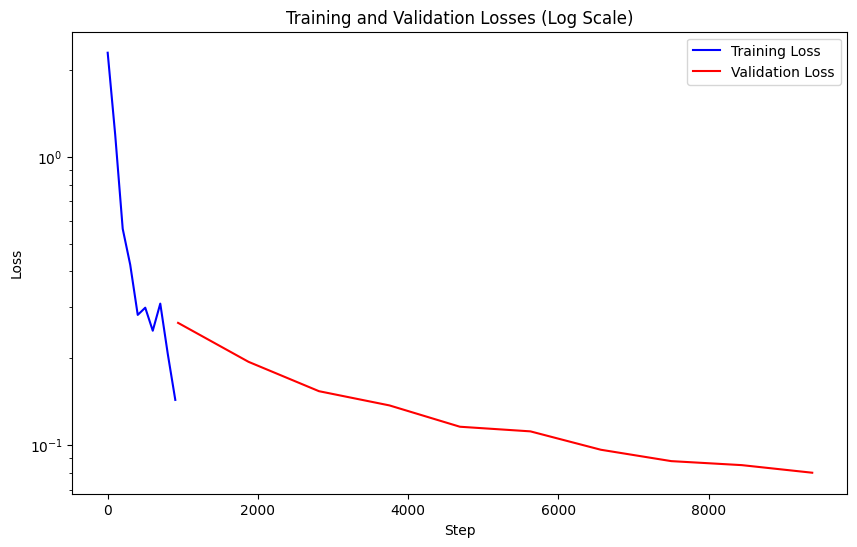

In [15]:
# visualize the losses for the first 10 epochs
import matplotlib.pyplot as plt

# Assuming train_losses and test_losses have been populated during training and testing

# For the first 10 epochs, we plot the losses
plt.figure(figsize=(10, 6))

# Plot training losses
plt.plot(train_steps[:10], train_losses[:10], label='Training Loss', color='blue')

# Plot test (validation) losses
plt.plot(test_steps[:10], test_losses[:10], label='Validation Loss', color='red')

# Set the scale of the y-axis to logarithmic
plt.yscale('log')

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Log Scale)')

# Add a legend
plt.legend()

# Display the plot
plt.show()


**Question 3**

The model may be able to train for a bit longer. Edit the cell below to modify the previous training code to also report the time per epoch and the time for 10 epochs with testing. You can use `time.time()` to get the current time in seconds.
Then run the model for another 10 epochs, printing out the execution time at the end, and replot the loss functions with the extra 10 epochs below.

In [16]:
# visualize the losses for 20 epochs
import time
import matplotlib.pyplot as plt

# Function to track time during training
for epoch in range(10, 20):  # Continue from epoch 10 to 19 for a total of 20 epochs
    start_time = time.time()  # Record the start time of the epoch

    # Train for one epoch
    current_step = cpu_train(epoch, train_losses, train_steps, current_step)

    # Test after training
    cpu_test(test_losses, test_accuracy, test_steps, current_step)

    # Measure time after epoch ends
    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds.')

    # Increment the epoch counter
    current_epoch += 1

# Calculate the total time for 10 additional epochs (epoch 10 to 19)
total_time = time.time() - start_time
print(f'\nTotal time for 10 epochs (with testing): {total_time:.2f} seconds.')



Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.071250: 100%|██████████| 938/938 [00:14<00:00, 64.34it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 72.58it/s]



Test set: Average loss: 0.0818, Accuracy: 9737/10000 (97%)

Epoch 11 completed in 16.75 seconds.


Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.049412: 100%|██████████| 938/938 [00:15<00:00, 62.23it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 60.79it/s]



Test set: Average loss: 0.0761, Accuracy: 9771/10000 (98%)

Epoch 12 completed in 17.68 seconds.


Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.100223: 100%|██████████| 938/938 [00:14<00:00, 64.54it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.87it/s]



Test set: Average loss: 0.0729, Accuracy: 9764/10000 (98%)

Epoch 13 completed in 16.67 seconds.


Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.013847: 100%|██████████| 938/938 [00:14<00:00, 63.93it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.89it/s]



Test set: Average loss: 0.0698, Accuracy: 9779/10000 (98%)

Epoch 14 completed in 16.78 seconds.


Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.159503: 100%|██████████| 938/938 [00:15<00:00, 61.24it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 74.06it/s]



Test set: Average loss: 0.0798, Accuracy: 9761/10000 (98%)

Epoch 15 completed in 17.45 seconds.


Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.038621: 100%|██████████| 938/938 [00:14<00:00, 64.94it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.46it/s]



Test set: Average loss: 0.0681, Accuracy: 9782/10000 (98%)

Epoch 16 completed in 16.54 seconds.


Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.007841: 100%|██████████| 938/938 [00:14<00:00, 64.57it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 64.42it/s]



Test set: Average loss: 0.0687, Accuracy: 9793/10000 (98%)

Epoch 17 completed in 16.98 seconds.


Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.036781: 100%|██████████| 938/938 [00:14<00:00, 62.97it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.75it/s]



Test set: Average loss: 0.0698, Accuracy: 9787/10000 (98%)

Epoch 18 completed in 17.04 seconds.


Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.012288: 100%|██████████| 938/938 [00:14<00:00, 64.45it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 72.96it/s]



Test set: Average loss: 0.0680, Accuracy: 9796/10000 (98%)

Epoch 19 completed in 16.72 seconds.


Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.022509: 100%|██████████| 938/938 [00:14<00:00, 64.51it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 53.44it/s]


Test set: Average loss: 0.0705, Accuracy: 9793/10000 (98%)

Epoch 20 completed in 17.49 seconds.

Total time for 10 epochs (with testing): 17.49 seconds.


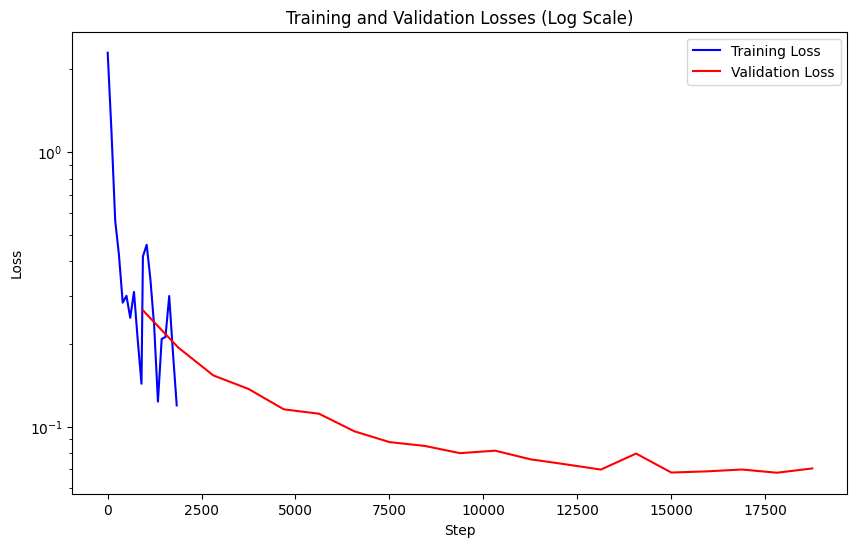

In [17]:
# Replot the losses for the first 20 epochs
plt.figure(figsize=(10, 6))

# Plot training losses
plt.plot(train_steps[:20], train_losses[:20], label='Training Loss', color='blue')

# Plot test (validation) losses
plt.plot(test_steps[:20], test_losses[:20], label='Validation Loss', color='red')

# Set the scale of the y-axis to logarithmic
plt.yscale('log')

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (Log Scale)')

# Add a legend
plt.legend()

# Display the plot
plt.show()


**Question 4**

Make an observation from the above plot. Do the test and train loss curves indicate that the model should train longer to improve accuracy? Or does it indicate that 20 epochs is too long? Edit the cell below to answer these questions.

The training loss is still decreasing and the test loss is flat or slightly decreasing, the model can continue training for a few more epochs, especially if the test loss hasn’t reached its minimum yet.


## Moving to the GPU

Now that you have a model trained on the CPU, let's finally utilize the T4 GPU that we requested for this instance.

Using a GPU with torch is relatively simple, but has a few gotchas. Torch abstracts away most of the CUDA runtime API, but has a few hold-over concepts such as moving data between devices.
Additionally, since the GPU is treated as a device separate from the CPU, you cannot combine CPU and GPU based tensors in the same operation. Doing so will result in a device mismatch error. If this occurs, check where the tensors are located (you can always print `.device` on a tensor), and make sure they have been properly moved to the correct device.

You will start by creating a new model, optimizer, and criterion (not really necessary in this case since you already did this above but it's better for clarity and completeness). However, one change that you'll make is moving the model to the GPU first. This can be done by calling `.cuda()` in general, or `.to("cuda")` to be more explicit. In general specific GPU devices can be targetted such as `.to("cuda:0")` for the first GPU (index 0), etc., but since there is only one GPU in Colab this is not necessary in this case.

In [18]:
# create the model
model = MLP()

# move the model to the GPU
model.cuda()

# for a critereon (loss) funciton, we will use Cross-Entropy Loss. This is the most common critereon used for multi-class prediction, and is also used by tokenized transformer models
# it takes in an un-normalized probability distribution (i.e. without softmax) over N classes (in our case, 10 classes with MNIST). This distribution is then compared to an integer label
# which is < N. For MNIST, the prediction might be [-0.0056, -0.2044,  1.1726,  0.0859,  1.8443, -0.9627,  0.9785, -1.0752, 1.1376,  1.8220], with the label 3.
# Cross-entropy can be thought of as finding the difference between what the predicted distribution and the one-hot distribution

criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [19]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [25]:
data = data.cuda()
target = target.cuda()

import time
import torch

# Function to track time during training
for epoch in range(10, 20):  # Continue from epoch 10 to 19 for a total of 20 epochs
    start_time = time.time()  # Record the start time of the epoch

    # Train for one epoch
    model.train()  # Set model to training mode
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, target) in pbar:
        # Move data and target to GPU
        data = data.cuda()
        target = target.cuda()

        # Zero the gradients before backpropagation
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()

        # Apply gradients
        optimizer.step()

        # Update step counter
        current_step += 1

        # Update progress bar
        if batch_idx % 100 == 0:
            train_losses.append(loss.item())
            train_steps.append(current_step)
            pbar.set_description(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                                 f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    # Measure time after epoch ends
    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1} completed in {epoch_time:.2f} seconds.')

    # Test after training
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0

    with torch.no_grad():
        pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

        for data, target in pbar:
            # Move data and target to GPU
            data = data.cuda()
            target = target.cuda()

            # Forward pass
            output = model(data)
            test_loss += criterion(output, target).item()

            # Compute accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy.append(correct / len(test_loader.dataset))
    test_steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Calculate the total time for the last 10 epochs (epoch 10 to 19)
total_time = time.time() - start_time
print(f'\nTotal time for 10 epochs (with testing): {total_time:.2f} seconds.')


Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.057679: 100%|██████████| 938/938 [00:15<00:00, 59.65it/s]


Epoch 11 completed in 15.73 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.83it/s]



Test set: Average loss: 0.0786, Accuracy: 9750/10000 (98%)



Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.053418: 100%|██████████| 938/938 [00:13<00:00, 67.11it/s]


Epoch 12 completed in 13.98 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.08it/s]



Test set: Average loss: 0.0779, Accuracy: 9761/10000 (98%)



Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.035589: 100%|██████████| 938/938 [00:14<00:00, 66.36it/s]


Epoch 13 completed in 14.14 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 55.18it/s]



Test set: Average loss: 0.0752, Accuracy: 9767/10000 (98%)



Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.079151: 100%|██████████| 938/938 [00:14<00:00, 66.25it/s]


Epoch 14 completed in 14.17 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 76.81it/s]



Test set: Average loss: 0.0734, Accuracy: 9767/10000 (98%)



Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.016529: 100%|██████████| 938/938 [00:14<00:00, 66.25it/s]


Epoch 15 completed in 14.16 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 73.96it/s]



Test set: Average loss: 0.0726, Accuracy: 9769/10000 (98%)



Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.021297: 100%|██████████| 938/938 [00:14<00:00, 66.54it/s]


Epoch 16 completed in 14.10 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 56.17it/s]



Test set: Average loss: 0.0708, Accuracy: 9780/10000 (98%)



Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.010828: 100%|██████████| 938/938 [00:14<00:00, 66.33it/s]


Epoch 17 completed in 14.15 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 77.47it/s]



Test set: Average loss: 0.0698, Accuracy: 9775/10000 (98%)



Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.022888: 100%|██████████| 938/938 [00:13<00:00, 67.95it/s]


Epoch 18 completed in 13.81 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 75.84it/s]



Test set: Average loss: 0.0702, Accuracy: 9777/10000 (98%)



Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.051657: 100%|██████████| 938/938 [00:16<00:00, 57.14it/s]


Epoch 19 completed in 16.42 seconds.


Testing...: 100%|██████████| 157/157 [00:03<00:00, 50.94it/s]



Test set: Average loss: 0.0703, Accuracy: 9773/10000 (98%)



Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.029705: 100%|██████████| 938/938 [00:16<00:00, 57.16it/s]


Epoch 20 completed in 16.43 seconds.


Testing...: 100%|██████████| 157/157 [00:02<00:00, 57.26it/s]


Test set: Average loss: 0.0726, Accuracy: 9769/10000 (98%)


Total time for 10 epochs (with testing): 19.18 seconds.


Now, copy your previous training code with the timing parameters below.
It needs to be slightly modified to move everything to the GPU.

Before the line `output = model(data)`, add:
```
data = data.cuda()
target = target.cuda()
```

Note that this is needed in both the train and test functions.

**Question 5**

Please edit the cell below to show the new GPU train and test fucntions.

In [23]:
# the new GPU training functions
import time
from tqdm import tqdm

def gpu_train(epoch, train_losses, steps, current_step, model, train_loader, optimizer, criterion):
    # Set the model in training mode
    model.train()

    # Create tqdm progress bar
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Training Epoch {epoch}")

    for batch_idx, (data, target) in pbar:
        # Move data and target to GPU
        data = data.cuda()
        target = target.cuda()

        # Zero the gradients before the backpropagation
        optimizer.zero_grad()

       # Forward pass
        output = model(data)

        # Compute loss
        loss = criterion(output, target)

        # Backpropagation
        loss.backward()

        # Apply gradients
        optimizer.step()

        # Increment global step count
        current_step += 1

        # Update progress bar and log training loss
        if batch_idx % 100 == 0:
            train_losses.append(loss.item())
            steps.append(current_step)
            pbar.set_description(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                                 f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

    return current_step



In [24]:
# new GPU training for 10 epochs
def gpu_test(test_losses, test_accuracy, steps, current_step, model, test_loader, criterion):
    # Set the model in evaluation mode
    model.eval()
    test_loss = 0
    correct = 0

    # Create tqdm progress bar for testing
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # No need for gradients during testing
    with torch.no_grad():
        for data, target in pbar:
            # Move data and target to GPU
            data = data.cuda()
            target = target.cuda()

            # Forward pass
            output = model(data)
            test_loss += criterion(output, target).item()

            # Compute accuracy by getting the index of the max output
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average test loss
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # Calculate accuracy
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracy.append(accuracy)

    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({accuracy:.0f}%)\n')


**Question 6**

Is training faster now that it is on a GPU? Is the speedup what you would expect? Why or why not? Edit the cell below to answer.

Yes, Without GPU 20 epochs completed in 17.49 secs where as with GPU 20 epochs completed in 14.18 secs

## Another Model Type: CNN

Until now you have trained a simple MLP for MNIST classification, however, MLPs are not a particularly good for images.

Firstly, using a MLP will require that all images have the same size and shape, since they are unrolled in the input.

Secondly, in general images can make use of translation invariance (a type of data symmetry), but this cannot but leveraged with a MLP.

For these reasons, a convolutional network is more appropriate, as it will pass kernels over the 2D image, removing the requirement for a fixed image size and leveraging the translation invariance of the 2D images.

Let's define a simple CNN below.

In [26]:
# Define the CNN model
class CNN(nn.Module):
    # define the constructor for the network
    def __init__(self):
        super().__init__()
        # instead of declaring the layers independently, let's use the nn.Sequential feature
        # these blocks will be executed in list order

        # you will break up the model into two parts:
        # 1) the convolutional network
        # 2) the prediction head (a small MLP)

        # the convolutional network
        self.net = nn.Sequential(
          nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # the input projection layer - note that a stride of 1 means you are not down-sampling
          nn.ReLU(),                                             # activation
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # an inner layer - note that a stride of 2 means you are down sampling. The output is 28x28 -> 14x14
          nn.ReLU(),                                             # activation
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),# an inner layer - note that a stride of 2 means you are down sampling. The output is 14x14 -> 7x7
          nn.ReLU(),                                             # activation
          nn.AdaptiveMaxPool2d(1),                               # a pooling layer which will output a 1x1 vector for the prediciton head
        )

        # the prediction head
        self.head = nn.Sequential(
          nn.Linear(128, 64),      # input projection, the output from the pool layer is a 128 element vector
          nn.ReLU(),               # activation
          nn.Linear(64, 10)        # class projection to one of the 10 classes (digits 0-9)
        )


    # define the forward pass compute graph
    def forward(self, x):

        # pass the input through the convolution network
        x = self.net(x)

        # reshape the output from Bx128x1x1 to Bx128
        x = x.view(x.size(0), -1)

        # pass the pooled vector into the prediction head
        x = self.head(x)

        # the output here is Bx10
        return x

In [27]:
# create the model
model = CNN()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then you can intantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a
# momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


**Question 7**

Notice that this model now has fewer parameters than the MLP. Let's see how it trains.

Using the previous code to train on the CPU with timing, edit the cell below to execute 2 epochs of training.

In [28]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [29]:
# train for 2 epochs on the CPU
import time

# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

# Train for 2 epochs with timing
for epoch in range(0, 2):
    start_time = time.time()  # Start timing the epoch

    current_step = cpu_train(current_epoch, train_losses, train_steps, current_step)
    cpu_test(test_losses, test_accuracy, test_steps, current_step)

    epoch_time = time.time() - start_time  # Calculate the time taken for this epoch
    print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds.")

    current_epoch += 1



Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.493148: 100%|██████████| 938/938 [01:16<00:00, 12.18it/s]
Testing...: 100%|██████████| 157/157 [00:06<00:00, 25.21it/s]



Test set: Average loss: 0.5423, Accuracy: 8207/10000 (82%)

Epoch 1 took 83.23 seconds.


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.208951: 100%|██████████| 938/938 [01:15<00:00, 12.41it/s]
Testing...: 100%|██████████| 157/157 [00:06<00:00, 22.49it/s]


Test set: Average loss: 0.2933, Accuracy: 9084/10000 (91%)

Epoch 2 took 82.56 seconds.


**Question 8**

Now, let's move the model to the GPU and try training for 2 epochs there.

In [30]:
# create the model
model = CNN()

model.cuda()

# print the model and the parameter count
print(model)
param_count = sum([p.numel() for p in model.parameters()])
print(f"Model has {param_count:,} trainable parameters")

# the loss function
criterion = nn.CrossEntropyLoss()

# then you can instantiate the optimizer. You will use Stochastic Gradient Descent (SGD), and can set the learning rate to 0.1 with a momentum factor of 0.5
# the first input to the optimizer is the list of model parameters, which is obtained by calling .parameters() on the model object
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

CNN(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveMaxPool2d(output_size=1)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)
Model has 101,578 trainable parameters


In [31]:
# create a new array to log the loss and accuracy
train_losses = []
train_steps = []
test_steps = []
test_losses = []
test_accuracy = []
current_step = 0  # Start with global step 0
current_epoch = 0 # Start with epoch 0

In [34]:
# train for 2 epochs on the GPU
def gpu_train(epoch, train_losses, steps, current_step):
    model.train()
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, target) in pbar:
        data, target = data.cuda(), target.cuda()  # Move data and target to GPU

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        current_step += 1

        if batch_idx % 100 == 0:
            train_losses.append(loss.item())
            steps.append(current_step)

            desc = (f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                    f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            pbar.set_description(desc)

    return current_step

def gpu_test(test_losses, test_accuracy, steps, current_step):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0

    # Create tqdm progress bar
    pbar = tqdm(test_loader, total=len(test_loader), desc="Testing...")

    # Use no_grad() as we do not need gradients for evaluation
    with torch.no_grad():
        for data, target in pbar:
            # Move data and target to the GPU
            data, target = data.cuda(), target.cuda()

            # Forward pass through the model
            output = model(data)
            test_loss += criterion(output, target).item()  # Add the loss for this batch

            # Calculate the number of correct predictions
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  # Compare predictions to the true labels

    test_loss /= len(test_loader)  # Calculate the average test loss

    # Log the test loss and accuracy
    test_losses.append(test_loss)
    test_accuracy.append(correct / len(test_loader.dataset))  # Accuracy as a fraction
    steps.append(current_step)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


# Train for 2 epochs with timing on GPU
for epoch in range(0, 2):
    start_time = time.time()  # Start timing the epoch

    current_step = gpu_train(current_epoch, train_losses, train_steps, current_step)  # Use GPU version of train function
    gpu_test(test_losses, test_accuracy, test_steps, current_step)  # Use GPU version of test function

    epoch_time = time.time() - start_time  # Calculate the time taken for this epoch
    print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds.")

    current_epoch += 1

Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.412111: 100%|██████████| 938/938 [00:15<00:00, 62.27it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 68.91it/s]



Test set: Average loss: 0.2596, Accuracy: 9204/10000 (92%)

Epoch 1 took 17.35 seconds.


Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.155251: 100%|██████████| 938/938 [00:15<00:00, 60.39it/s]
Testing...: 100%|██████████| 157/157 [00:02<00:00, 59.29it/s]


Test set: Average loss: 0.1737, Accuracy: 9457/10000 (95%)

Epoch 2 took 18.20 seconds.


**Question 9**

How do the CPU and GPU versions compare for the CNN? Is one faster than the other? Why do you think this is, and how does it differ from the MLP? Edit the cell below to answer.

For CPU version Epoch 1 took 83.23 seconds and Epoch 2 took 82.56 seconds.

For GPU version Epoch 1 took 17.35 seconds and Epoch 2 took 18.20 seconds.

The GPU version is faster for several reasons:

1. Parallelization:
GPU: GPUs are designed to perform many operations simultaneously. They excel at handling parallel tasks, especially for operations like matrix multiplications, convolutions, and other tensor-based operations, which are common in deep learning. The large number of cores in GPUs allows them to execute many computations at once, significantly speeding up tasks such as training and inference in deep neural networks.
CPU: The CPU has fewer cores (typically 4 to 16), which makes it more suited for single-threaded tasks, and while it can execute parallel operations, it does so with far fewer resources compared to a GPU. This limits its ability to efficiently handle large-scale operations like those required in deep learning.
2. CNN vs MLP (Multi-Layer Perceptron):
MLP: A Multi-Layer Perceptron is a fully connected network where each neuron in a layer is connected to every neuron in the next layer. This creates a large number of parameters, and each input feature is multiplied by all weights in the layer, making the computation intensive, especially for large datasets like images. While the computations themselves can be parallelized, the dense connections in an MLP can result in fewer advantages from GPU acceleration compared to a convolutional approach.
CNN: A Convolutional Neural Network (CNN) is specifically designed for image data and utilizes convolutional layers that apply filters (kernels) across the input image. These convolutional operations are highly parallelizable because:
The same filter is applied repeatedly across different parts of the image, allowing for efficient computation of feature maps.
Convolutions are localized, meaning fewer parameters need to be learned per filter, which makes the process less computationally expensive than an MLP.
CNNs often have pooling layers that downsample the feature maps, reducing the size of the data and computation required in later layers.

Key Differences in Operation:
MLP requires flattening the entire image into a vector before feeding it into the network. This means the input image size must be fixed, and every pixel is connected to every node in the network. For large images, this can result in a huge number of weights and computations.

CNN works directly with the 2D structure of the image, applying filters across small regions (local receptive fields) to capture spatial hierarchies in the data. The convolution operation, combined with pooling, reduces the computational complexity by reducing the number of connections and focusing on local features first before moving on to higher-level features.

Why CNNs Are Faster:
CNNs exploit the spatial structure of images by applying filters locally, which reduces the number of parameters compared to MLPs.
CNNs benefit greatly from GPUs because convolutions and matrix multiplications can be performed in parallel, taking full advantage of the GPU's parallel processing capabilities.
The use of pooling layers in CNNs reduces the data size, meaning fewer computations are needed as the network progresses.

In summary, the GPU is faster because it can handle parallel operations more efficiently, and CNNs are faster than MLPs on image data due to their local, sparse connections and the ability to exploit spatial hierarchies, making them more computationally efficient for tasks like image classification.

As a final comparison, you can profile the FLOPs (floating-point operations) executed by each model. You will use the thop.profile function for this and consider an MNIST batch size of 1.

In [35]:
# the input shape of a MNIST sample with batch_size = 1
input = torch.randn(1, 1, 28, 28)

# create a copy of the models on the CPU
mlp_model = MLP()
cnn_model = CNN()

# profile the MLP
flops, params = thop.profile(mlp_model, inputs=(input, ), verbose=False)
print(f"MLP has {params:,} params and uses {flops:,} FLOPs")

# profile the CNN
flops, params = thop.profile(cnn_model, inputs=(input, ), verbose=False)
print(f"CNN has {params:,} params and uses {flops:,} FLOPs")

MLP has 109,386.0 params and uses 109,184.0 FLOPs
CNN has 101,578.0 params and uses 7,459,968.0 FLOPs


**Question 10**

Are these results what you would have expected? Do they explain the performance difference between running on the CPU and GPU? Why or why not? Edit the cell below to answer.

Even though the CNN has fewer parameters than the MLP, it has a significantly higher number of FLOPs. This is because convolutions require computing the dot product of filters with patches of the input image. These operations are computationally expensive due to the number of times the kernel is applied across the entire image.

Additionally, CNNs often perform more advanced operations like pooling, activation functions, and downsampling, all of which contribute to the high FLOPs count.
However, the CNN has fewer parameters because it shares weights across the entire image, making it more efficient in terms of parameterization.